In [1]:
import os
import re
import SMBcorr
import h5py
import numpy as np
import pointCollection as pc
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
# choose file to read and append
value=''
inputText = widgets.Text(
    value=value,
    description='File:',
    disabled=False
)

# text menu to set model base directory
value=os.getcwd()
directoryText = widgets.Text(
    value=value,
    description='Directory:',
    disabled=False
)


# dropdown menu for setting region
regionDropdown = widgets.Dropdown(
    options=['AA','GL'],
    value='GL',
    description='Region:',
    disabled=False,
)

# dropdown menu for setting SMB model
modelDropdown = widgets.Dropdown(
    options=['MAR','RACMO'],
    value='RACMO',
    description='Model:',
    disabled=False,
)

# dropdown menu for setting model version
models = dict(AA={}, GL={})
models['GL']['MAR'] = ['MARv3.9-ERA','MARv3.10-ERA','MARv3.11-NCEP','MARv3.11-ERA']
models['GL']['RACMO'] = ['RACMO2.3-XGRN11','RACMO2.3p2-FGRN11','RACMO2.3p2-FGRN055']
versionDropdown = widgets.Dropdown(
    options=models[regionDropdown.value][modelDropdown.value],
    value=models[regionDropdown.value][modelDropdown.value][-1],
    description='Version:',
    disabled=False,
)

# function for updating the model version
def set_version(sender):
    versionDropdown.options=models[regionDropdown.value][modelDropdown.value]
    versionDropdown.value=models[regionDropdown.value][modelDropdown.value][-1]

# watch widgets for changes
regionDropdown.observe(set_version)
modelDropdown.observe(set_version)

# display widgets for setting parameters
widgets.VBox([inputText,directoryText,regionDropdown,
    modelDropdown,versionDropdown])

In [3]:
# PURPOSE: convert time from delta seconds into Julian and year-decimal
def convert_delta_time(delta_time, gps_epoch=1198800018.0):
    # calculate gps time from delta_time
    gps_seconds = gps_epoch + delta_time
    time_leaps = SMBcorr.count_leap_seconds(gps_seconds)
    # calculate julian time
    time_julian = 2444244.5 + (gps_seconds - time_leaps)/86400.0
    # convert to calendar date with convert_julian.py
    Y,M,D,h,m,s = SMBcorr.convert_julian(time_julian,FORMAT='tuple')
    # calculate year-decimal time
    time_decimal = SMBcorr.convert_calendar_decimal(Y,M,DAY=D,HOUR=h,MINUTE=m,SECOND=s)
    # return both the Julian and year-decimal formatted dates
    return dict(julian=time_julian, decimal=time_decimal)

In [4]:
# PURPOSE: set the projection parameters based on the region name
def set_projection(REGION):
    if (REGION == 'AA'):
        projection_flag = 'EPSG:3031'
    elif (REGION == 'GL'):
        projection_flag = 'EPSG:3413'
    return projection_flag

In [5]:
# read input file
input_file = os.path.expanduser(inputText.value)
field_dict = {None:('delta_time','dem_h','file_ind',
    'h_corr','h_corr_sigma','latitude','longitude',
    'quality_summary','x','y')}
D11 = pc.data().from_h5(input_file, field_dict=field_dict)
nseg,ncycle = D11.shape

# get projection of input coordinates
EPSG = set_projection(regionDropdown.value)

# extract parameters from widgets
base_dir=os.path.expanduser(directoryText.value)
if (modelDropdown.value == 'MAR'):
    VERSION,=re.findall('MARv\d+\.\d+',versionDropdown.value)
    REGION=dict(GL='Greenland',AA='Antarctic')[regionDropdown.value]
    SUBDIRECTORY={}
    SUBDIRECTORY['MARv3.9-ERA']=['ERA_1958-2018_10km','daily_10km']
    SUBDIRECTORY['MARv3.10-ERA']=['ERA_1958-2019-15km','daily_15km']
    SUBDIRECTORY['MARv3.11-NCEP']=['NCEP1_1948-2020_20km','daily_20km']
    SUBDIRECTORY['MARv3.11-ERA']=['ERA_1958-2019-15km','daily_15km']
    MODEL=SUBDIRECTORY[versionDropdown.value]
    DIRECTORY=os.path.join(base_dir,'MAR',VERSION,REGION,*MODEL)
elif (modelDropdown.value == 'RACMO'):
    VERSION,MODEL=versionDropdown.value.split('-')

# for each cycle of ICESat-2 ATL11 data
FIRN = np.ma.zeros((nseg,ncycle),fill_value=np.nan)
for c in range(ncycle):
    i, = np.nonzero(np.isfinite(D11.delta_time[:,c]))
    # convert from delta time to decimal-years
    tdec = convert_delta_time(D11.delta_time[i,c])['decimal']
    if (modelDropdown.value == 'MAR'):
        # read and interpolate daily MAR outputs
        FIRN[i,c] = SMBcorr.interpolate_mar_daily(DIRECTORY, EPSG, VERSION,
            tdec, D11.x[i,c], D11.y[i,c], VARIABLE='ZN6', SIGMA=1.5,
            FILL_VALUE=np.nan)
    elif (modelDropdown.value == 'RACMO'):
        # read and interpolate daily RACMO outputs
        FIRN[i,c] = SMBcorr.interpolate_racmo_daily(base_dir, EPSG, MODEL,
            tdec, D11.x[i,c], D11.y[i,c], VARIABLE='hgtsrf', SIGMA=1.5,
            FILL_VALUE=np.nan)
# replace mask values
FIRN.mask = (FIRN.data == FIRN.fill_value)

/home/tyler/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/tyler/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/home/tyler/local/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis

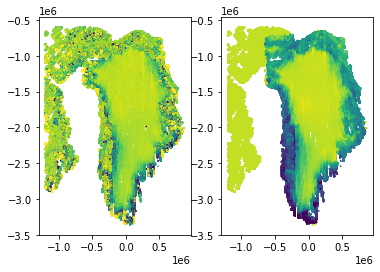

In [8]:
# create a plot showing elevation change and firn height change
fig,(ax1,ax2) = plt.subplots(ncols=2)
c1,c2 = (0,1)
i, = np.nonzero(np.isfinite(D11.h_corr[:,c1]) & np.isfinite(D11.h_corr[:,c2]) & 
    (~FIRN.mask[:,c1]) & (~FIRN.mask[:,c2]))
# height change
ax1.scatter(D11.x[i,c1],D11.y[i,c1],
    c=D11.h_corr[i,c2]-D11.h_corr[i,c1],
    vmin=-5,vmax=0.5,s=0.5)
# firn height change
ax2.scatter(D11.x[i,c1],D11.y[i,c1],
    c=FIRN[i,c2]-FIRN[i,c1],
    vmin=-5,vmax=0.5,s=0.5)
plt.show()

In [ ]:
# append input HDF5 file with new firn model outputs
fileID = h5py.File(os.path.expanduser(inputText.value),'a')
fileID.create_group(versionDropdown.value)
h5 = {}
val = '{0}/{1}'.format(versionDropdown.value,'zsurf')
h5['zsurf'] = fileID.create_dataset(val, FIRN.shape, data=FIRN,
    dtype=FIRN.dtype, compression='gzip', fillvalue=FIRN.fill_value)
h5['zsurf'].attrs['units'] = "m"
h5['zsurf'].attrs['long_name'] = "Snow Height Change"
h5['zsurf'].attrs['coordinates'] = "../delta_time ../latitude ../longitude"
h5['zsurf'].attrs['model'] = versionDropdown.value
fileID.close()